
# Importing Libraries for time series forecasting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

#  Importing data

Dataset: International airline passengers


In [2]:
p1=pd.read_csv('international-airline-passengers.csv')
p1.columns = ['year','passengers']

In [3]:
p1.head()

,year,passengers
0,1949-02,118
1,1949-03,132
2,1949-04,129
3,1949-05,121
4,1949-06,135


In [4]:
p1.shape

(143, 2)

# Data Preprocessing and Visualization
Converting to datetime format:

In [5]:
p1['year'] = pd.to_datetime(p1['year'], format='%Y-%m')

In [7]:
p1.index=p1['year']
p1.index

DatetimeIndex(['1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01',
               '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01',
               '1949-10-01', '1949-11-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='year', length=143, freq=None)

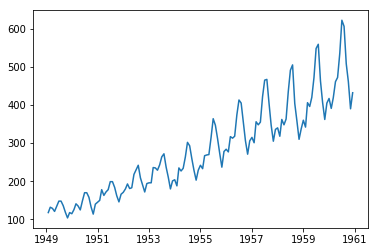

In [14]:
plt.plot(p1['passengers'])

# Stationarity
A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.

We can check stationarity using the following:


Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.


Augmented Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. 

In [15]:
def test_stationarity(timeseries):
    rolmean=timeseries.rolling(24).mean()
    rolstd=timeseries.rolling(24).std()
    
    
    orig=plt.plot(timeseries,color='blue',label='original')
    mean=plt.plot(rolmean,color='red',label='rolmean')
    std=plt.plot(rolstd,color='green',label='rolstd')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xticks(rotation=30)
    plt.show(block=False)
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

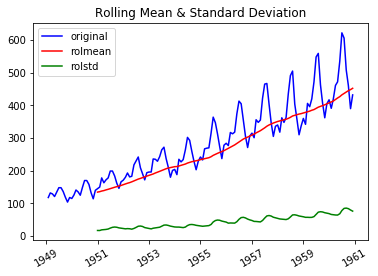

Results of Dickey-Fuller Test:
Test Statistic                   0.792340
p-value                          0.991512
#Lags Used                      13.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


In [16]:
test_stationarity(p1['passengers'])

# Making Time Series Stationary

There are 2 major reasons behind non-stationarity of a TS:

Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.

Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.


# Transformations

We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

Log Scale Transformation

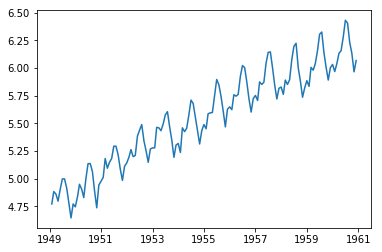

In [18]:
ts_log = np.log(p1['passengers'])
plt.plot(ts_log)


# Techniques to remove Trend - Smoothing

Smoothing is taking rolling averages over windows of time

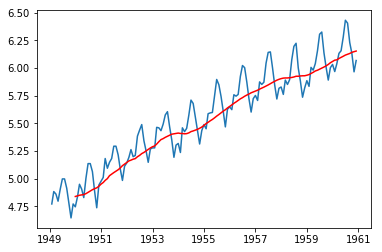

In [21]:
rolmean=ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(rolmean, color='red')

In [27]:
ts_log_moving_avg_diff = ts_log - rolmean
ts_log_moving_avg_diff.head(12)

year
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01         NaN
1950-01-01   -0.093449
Name: passengers, dtype: float64

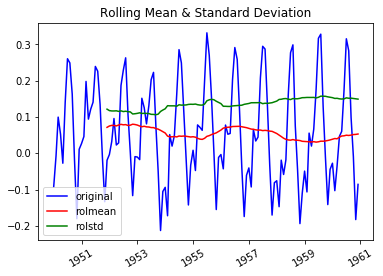

Results of Dickey-Fuller Test:
Test Statistic                  -3.151143
p-value                          0.022993
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [28]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

# Further Techniques to remove Seasonality and Trend

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality.

# Differencing

In this technique, we take the difference of the observation at a particular instant with that at the previous instant.


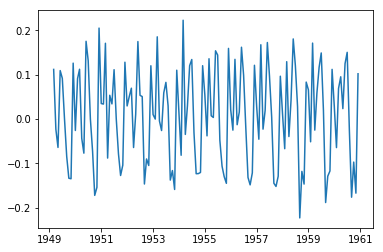

In [30]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

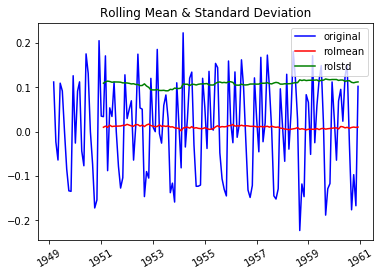

Results of Dickey-Fuller Test:
Test Statistic                  -2.877449
p-value                          0.048034
#Lags Used                      14.000000
Number of Observations Used    127.000000
Critical Value (1%)             -3.482920
Critical Value (5%)             -2.884580
Critical Value (10%)            -2.579058
dtype: float64


In [31]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# Decomposition
In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

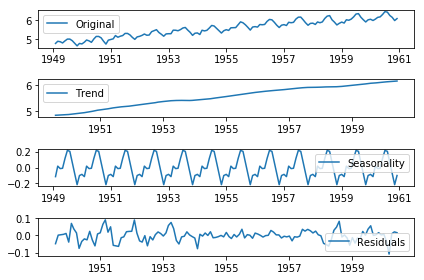

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

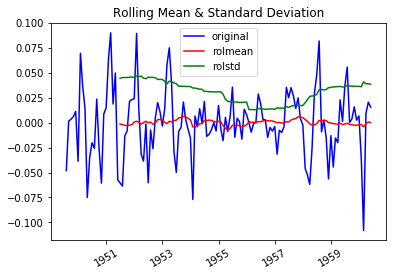

Results of Dickey-Fuller Test:
Test Statistic                -6.676255e+00
p-value                        4.457465e-09
#Lags Used                     9.000000e+00
Number of Observations Used    1.210000e+02
Critical Value (1%)           -3.485585e+00
Critical Value (5%)           -2.885739e+00
Critical Value (10%)          -2.579676e+00
dtype: float64


In [34]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Autoregressive Integrated Moving Average (ARIMA)

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

Number of AR (Auto-Regressive) terms (p): p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

Number of Differences (d): d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.

Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

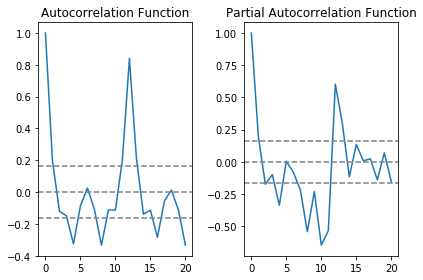

In [36]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray') 
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

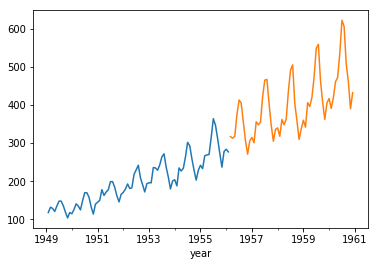

In [52]:
#divide into train and validation set
train = p1[:int(0.60*(len(p1)))]
valid = p1[int(0.60*(len(p1))):]

#plotting the data
train['passengers'].plot()
valid['passengers'].plot()

In [53]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(p1['passengers'], order=(1, 1, 1))
model_fit = model.fit(disp=1)

In [55]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [56]:
# report performance
mse = mean_squared_error(p1.passengers[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 410.1832267708364, MSE:168250.27952413543


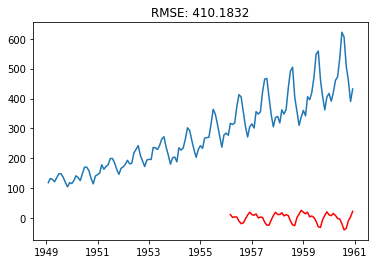

In [57]:
plt.plot(p1.passengers)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

Fitted or predicted values:

In [58]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

1956-03-01    11.174319
1956-04-01     1.762021
1956-05-01     3.420516
1956-06-01     2.816533
1956-07-01   -10.511154
Freq: MS, dtype: float64


Cumulative Sum to reverse differencing:

In [59]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

1956-03-01    11.174319
1956-04-01    12.936340
1956-05-01    16.356856
1956-06-01    19.173389
1956-07-01     8.662235
Freq: MS, dtype: float64


Adding 1st month value which was previously removed while differencing:

In [61]:
predictions_ARIMA_log = pd.Series(valid.passengers.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1956-03-01    328.174319
1956-04-01    329.936340
1956-05-01    333.356856
1956-06-01    336.173389
1956-07-01    325.662235
dtype: float64

Text(0.5,1,'RMSE: 57.6321')

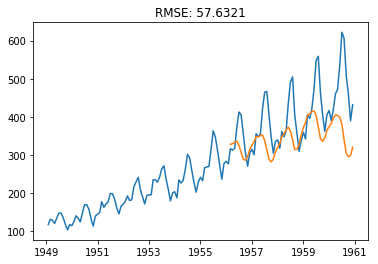

In [65]:
plt.plot(p1.passengers)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-p1.passengers)**2)/len(p1.passengers)))

In [66]:
mse = mean_squared_error(p1.passengers[start_index:end_index],predictions_ARIMA_log)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 90.49366673146837, MSE:8189.103718506065


# Seasonal Autoregressive Integrated Moving-Average (SARIMA)

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

Trend Elements:

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

p: Trend autoregression order.

d: Trend difference order.

q: Trend moving average order.

Seasonal Elements:

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

P: Seasonal autoregressive order.

D: Seasonal difference order.

Q: Seasonal moving average order.

m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

SARIMA notation: SARIMA(p,d,q)(P,D,Q,m)

In [76]:
# fit model
model = SARIMAX(p1['passengers'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

In [77]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [78]:
mse = mean_squared_error(p1.passengers[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 13.241811740049043, MSE:175.34557815890065


Text(0.5,1,'RMSE: 13.2418')

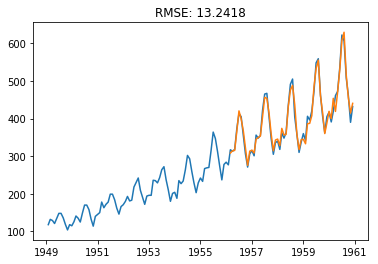

In [79]:
plt.plot(p1['passengers'])
plt.plot(predictions)
plt.title('RMSE: %.4f'% rmse)

# Tuned SARIMA

In [85]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)


In [86]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(p1['passengers'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:2030.9986180694207
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1873.4960217320477
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:1306.8396300670177


/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:1147.1843419409388
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1110.827113238785
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1099.8264761181476
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1099.7434243515154
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1025.716791639056
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:1834.0704384783917
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:1557.1101766559036
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:1188.7823330273404
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:1062.4370147386853
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1063.5950654272851
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1042.5334645824041
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:1049.9651962010182
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:976.9245836217132
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:1395.946641650144
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1186.460657867845
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:1017.6060377345153
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:929.8029289704366
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:1024.4891597228832
ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:1175.5160022946957
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:1001.7257303388628
ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:915.4066959470355
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:1002.4854660677817
ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:980.47513883258
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:921.8434902947652
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:915.1400294720218


We got the lowest AIC value: 915.14 for ARIMA(1, 1, 1)x(1, 1, 1, 12). We shall use these best params in our model.

Here, the Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

AIC estimates the relative amount of information lost by a given model: the less information a model loses (less AIC value), the higher the quality of that model.

In [87]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

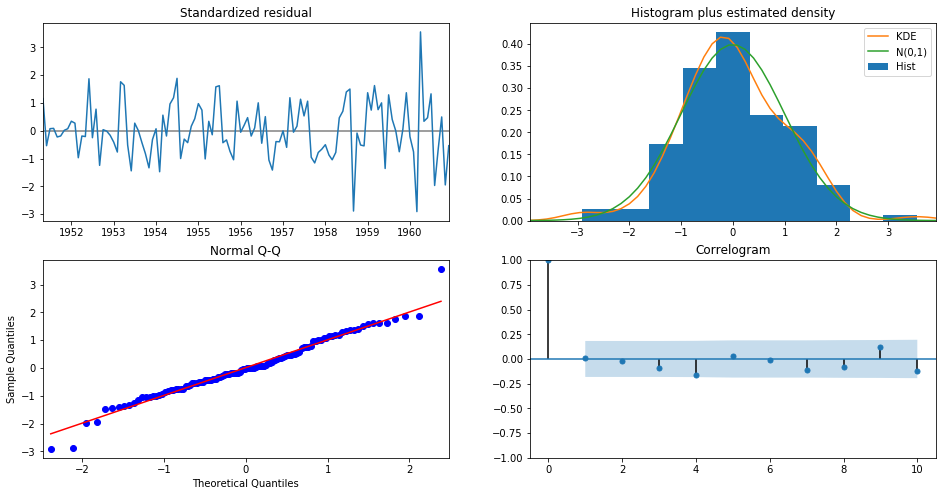

In [88]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [93]:
y_forecasted = pred.predicted_mean.values
y_truth = p1.passengers[start_index:end_index].values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 182.34
The Root Mean Squared Error of our forecasts is 13.5
